# Plotting the Performances

Plot the performance of the best performing model (Bio+ClinicalBERT).

Create four panel graphics again:

A) | B)

C) | D)

A) & B) are bar charts for the per-class performance
C) & D) are confusion matricies 

Left is internal data set, right is external data set

**Confusion Matrix**
Flatten predictions and create confusion matrix for predictions with only label.


## Import data and libraries

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# SKlearn imports for model evaluation
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
# Rename the columns
column_mapper = {
    "urinary": "Urinary",
    "respiratory": "Respiratory",
    "abdominal": "Abdominal",
    "neurological": "Neurological",
    "skin_soft_tissue": "Skin & Soft Tissue",
    "ent": "ENT",
    "orthopaedic": "Orthopaedic",
    "other_specific": "Other Specific",
    "no_specific_source": "No Specific Source",
    "prophylaxis": "Prophylaxis",
    "uncertainty": "Uncertainty",
    "not_informative": "Not Informative"
}

In [3]:
# Categories
categories = ["Urinary", "Respiratory", "Abdominal", "Neurological", "Skin & Soft Tissue", "ENT", "Orthopaedic", "Other Specific", "No Specific Source", "Prophylaxis", "Uncertainty", "Not Informative"]
categories.sort()

# All without "Uncertainty"
categoires_no_uncertainty = categories.copy()
categoires_no_uncertainty.remove("Uncertainty")

In [4]:
# Import the data
data_dir = Path('../00_Data')
model_name = 'Bio_ClinicalBERT'

plot_dir = data_dir / "export" / model_name / "plots"
test_location_list = ["oxford", "banbury"]

# Load the data
pred_dict = {}
true_dict = {}

for test_location in test_location_list:
    # Predicted labels
    pred_dict[test_location] = pl.read_csv(data_dir / 'export' / model_name / f'{model_name}_{test_location}_predictions.csv')\
    .rename(column_mapper)
    # True labels
    true_dict[test_location] = pl.read_csv(data_dir / "publication_ready" / f"testing_{test_location}_2023-08-23.csv")\
    .drop("PrescriptionID")\
    .rename(column_mapper)

## Investigate Dataset
Did I mix up true and predicted labels in the confusion matrix?

In [5]:
(true_dict["banbury"]\
    .select(categoires_no_uncertainty)
    .filter(pl.col("Not Informative") == 1)
    .filter(pl.sum_horizontal("*") == 1)
)

Abdominal,ENT,Neurological,No Specific Source,Not Informative,Orthopaedic,Other Specific,Prophylaxis,Respiratory,Skin & Soft Tissue,Urinary
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64


## Confusion Matrix

> Create confusion matrix for single category true predictions

The basic steps are: Get the sources per indication, join both, filter for multiple entries, export

0. Give each result an unique ID (we treat "Indication" as the ID in the following)
1. Pivot longer `[Indication, Source, Value]`
2. Filter for `Value == 1`
3. Aggregate per Indication, so that we save a `[Indication, [Sources]]`
4. Repeat 1.-3. for both true and pred
5. Concatenate both
6. Filter for true `len([Source]) == 1` 
    6a. Filter for pred the same? Or duplicate rows if multiple sources occur
7. Export two series, which are now flat


TODO CHECK TRUE AND PRED ARE CORRECT???

In [6]:
def sparse_to_long_dense(input_df):
    """ Keep the ID and convert the sparse matrix into a denser dataframe (basically pivoted longer)
    """
    return (input_df
        # 0. Give unique ID
        .with_row_index(name="ID")
        # 1. Pivot longer (melt)
        .melt(
            id_vars=["ID"],
            value_vars=categoires_no_uncertainty,
            variable_name="Source",
            value_name="Value",
        )
        # 2. Filter for only hits
        .filter(
            pl.col("Value") == 1,
        )
        # 3. Aggregate
        .group_by(["ID"])
        .agg(
            pl.col("Source").alias("Sources")
        )
        .sort("ID")
    )


def multi_label_to_multi_class(true_df, pred_df):
    """ Convert the multi label matrix to a flat list of predicted labels
    """
    # Run Step 1-3, flatten the dataframe
    true_flattened_df = sparse_to_long_dense(true_df)
    pred_flattened_df = sparse_to_long_dense(pred_df)

    # 5. Concatenate the dataframe (perform join to verify integrity)
    flattened_joined_df = true_flattened_df.join(
        pred_flattened_df,
        on="ID",
        how="inner",
        suffix="_pred",
        validate="1:1",
        )

    # 6. Filter for single source in true labels
    flattened_joined_filtered_df = (flattened_joined_df
        .filter(
            pl.col("Sources").list.len() <= 1,
        )
        .with_columns(
            pl.col("Sources").list.first(),  # Expand the list (single element list)
        )
        .explode("Sources_pred")  # Multiple predictions get expanded
    )

    flattened_joined_filtered_df

    # 7. Get flat lists
    true_list = flattened_joined_filtered_df["Sources"].to_list()
    pred_list = flattened_joined_filtered_df["Sources_pred"].to_list()

    return true_list, pred_list

# Run the conversion function for both locations
pred_flat_dict = {}
true_flat_dict = {}

for test_location in test_location_list:
    pred_flat_dict[test_location], true_flat_dict[test_location] = \
        multi_label_to_multi_class(true_dict[test_location], pred_dict[test_location])
    

Missing labels: {'Not Informative'}
Missing labels: set()


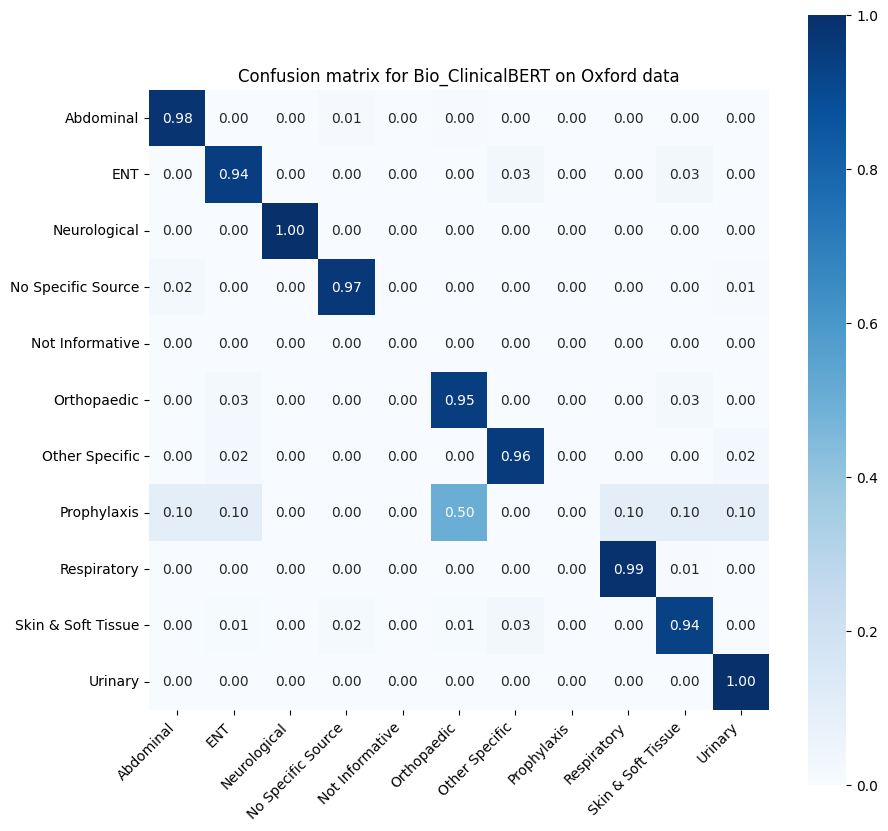

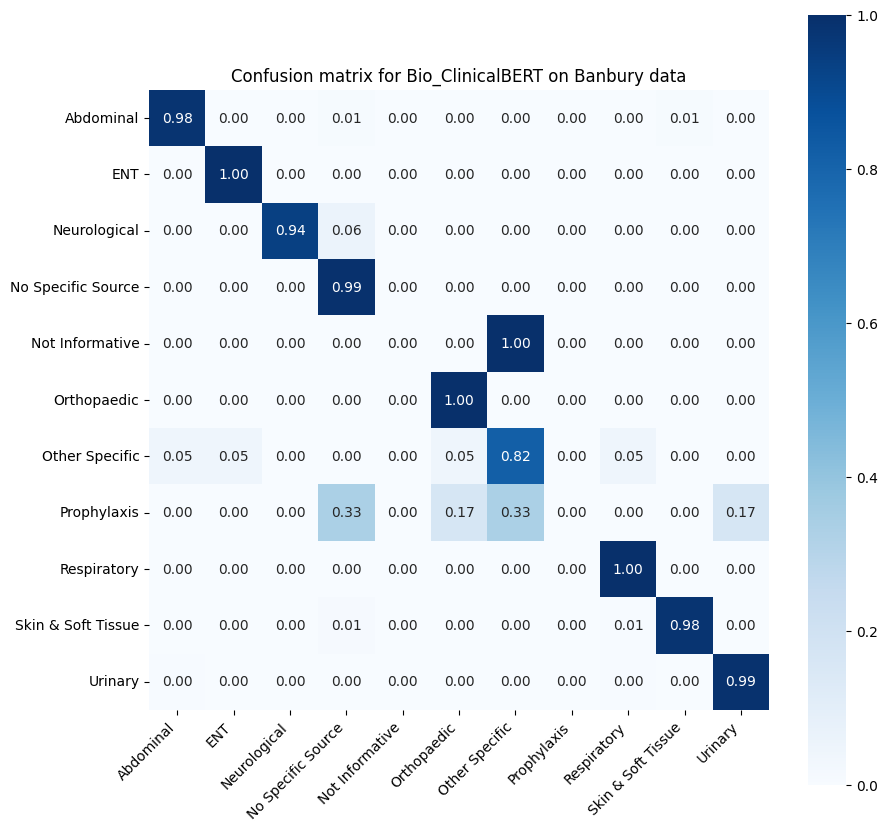

In [7]:
def plot_confusion_matrix(true_list, pred_list, test_location):
    cm_labels = list(set(true_list + pred_list))
    cm_labels.sort()

    print("Missing labels:", set(categoires_no_uncertainty) - set(cm_labels))

    # Plot confusion matrix, filter for only entries with one true label
    cm = confusion_matrix(
        true_list, 
        pred_list,
        labels=categoires_no_uncertainty,
        normalize='true')

    # Plot the confusion matrix
    figure = plt.figure(figsize=(10, 10))
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion matrix for {model_name} on {test_location.capitalize()} data')

    g = sns.heatmap(
        cm,
        square=True,
        annot=True,
        cmap='Blues',
        fmt='.2f',
        vmin=0,
        vmax=1,
        xticklabels=categoires_no_uncertainty,
        yticklabels=categoires_no_uncertainty
        )
    g.set_xticklabels(g.get_xticklabels(), rotation = 45, ha="right")

    # plt.savefig(plot_dir / f"{model_name}_{test_location}_confusion_matrix.png", dpi=300, bbox_inches='tight')
    # Convert to long format for export
    cm_long = (
        pl.DataFrame(cm, schema=categoires_no_uncertainty)
        .with_columns(
            pl.Series("True Label", categoires_no_uncertainty),
        )
        .melt(id_vars=["True Label"], value_vars=categoires_no_uncertainty, variable_name="Predicted Label", value_name="Value")
    )

    return figure, cm_long

# Plot the confusion matrix
cm_plot_dict = {}
cm_long_dict = {}
for test_location in test_location_list:
    figure, cm_long = plot_confusion_matrix(true_flat_dict[test_location], pred_flat_dict[test_location], test_location)
    cm_plot_dict[test_location] = figure
    cm_long_dict[test_location] = cm_long
    figure.show()

## Performance Bar Chart

In [8]:
f1_scores_dict = {}

for test_location in test_location_list:
    true_df = true_dict[test_location]
    pred_df = pred_dict[test_location]

    # Calculate F1 scores
    f1_scores_dict[test_location] = pl.DataFrame({
        "Source": categories,
        "F1 Score": f1_score(y_true=true_df[categories], y_pred=pred_df[categories], average=None)
    })

f1_scores_dict

{'oxford': shape: (12, 2)
 ┌────────────────────┬──────────┐
 │ Source             ┆ F1 Score │
 │ ---                ┆ ---      │
 │ str                ┆ f64      │
 ╞════════════════════╪══════════╡
 │ Abdominal          ┆ 0.957627 │
 │ ENT                ┆ 0.847826 │
 │ Neurological       ┆ 0.878049 │
 │ No Specific Source ┆ 0.980198 │
 │ Not Informative    ┆ 0.866667 │
 │ …                  ┆ …        │
 │ Prophylaxis        ┆ 0.984353 │
 │ Respiratory        ┆ 0.982456 │
 │ Skin & Soft Tissue ┆ 0.936803 │
 │ Uncertainty        ┆ 0.962751 │
 │ Urinary            ┆ 0.974359 │
 └────────────────────┴──────────┘,
 'banbury': shape: (12, 2)
 ┌────────────────────┬──────────┐
 │ Source             ┆ F1 Score │
 │ ---                ┆ ---      │
 │ str                ┆ f64      │
 ╞════════════════════╪══════════╡
 │ Abdominal          ┆ 0.951965 │
 │ ENT                ┆ 0.962963 │
 │ Neurological       ┆ 0.972973 │
 │ No Specific Source ┆ 0.988506 │
 │ Not Informative    ┆ 0.83871  │
 

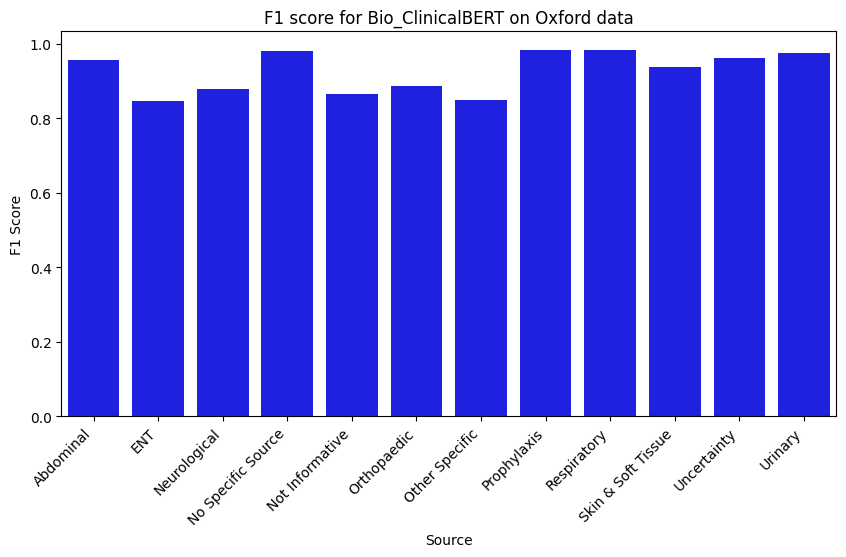

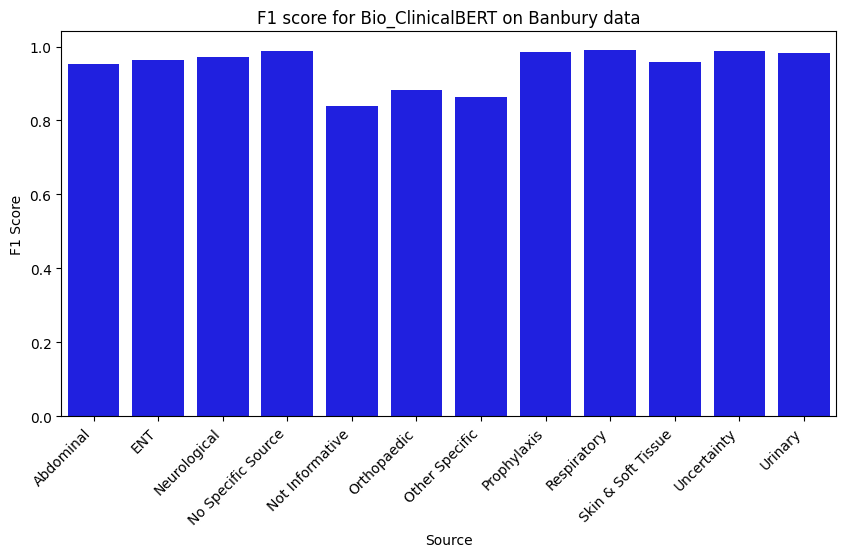

In [9]:
f1_plot_dict = {}

for test_location in test_location_list:
    # Define the figure
    figure = plt.figure(figsize=(10, 5))
    plt.title(f'F1 score for {model_name} on {test_location.capitalize()} data')

    # Plot Barplot
    g = sns.barplot(
        data=f1_scores_dict[test_location].to_pandas(),
        x="Source",
        y="F1 Score",
        color="blue",
        order=categories
        )
    g.set_xticklabels(g.get_xticklabels(), rotation = 45, ha="right")
    figure.show()

    f1_plot_dict[test_location] = figure


## Assemble the plots

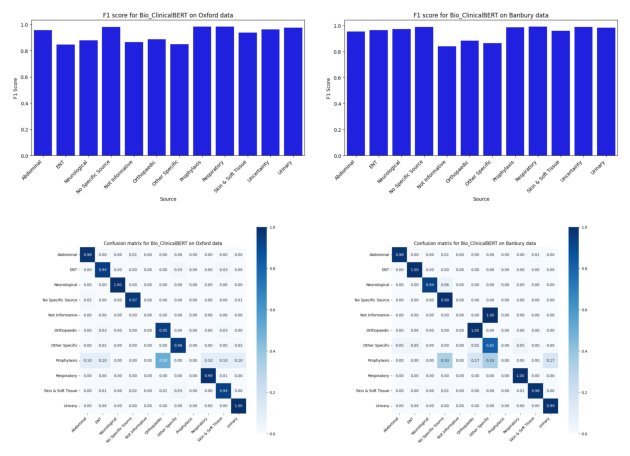

In [10]:
fig, axs = plt.subplots(2,2)

axs[0, 0].imshow(np.array(f1_plot_dict["oxford"].canvas.renderer.buffer_rgba()))
axs[0, 0].axis('off')
axs[0, 1].imshow(np.array(f1_plot_dict["banbury"].canvas.renderer.buffer_rgba()))
axs[0, 1].axis('off')
axs[1, 0].imshow(np.array(cm_plot_dict["oxford"].canvas.renderer.buffer_rgba()))
axs[1, 0].axis('off')
axs[1, 1].imshow(np.array(cm_plot_dict["banbury"].canvas.renderer.buffer_rgba()))
axs[1, 1].axis('off')

plt.tight_layout()

## Replot in `plotnine`

In [11]:
from plotnine import (
    ggplot,
    aes,
    geom_tile,
    geom_text,
    scale_y_reverse,
    scale_y_discrete,
    scale_fill_brewer,
    scale_color_manual,
    coord_equal,
    theme,
    theme_void,
    element_blank,
    element_rect,
    element_text,
)

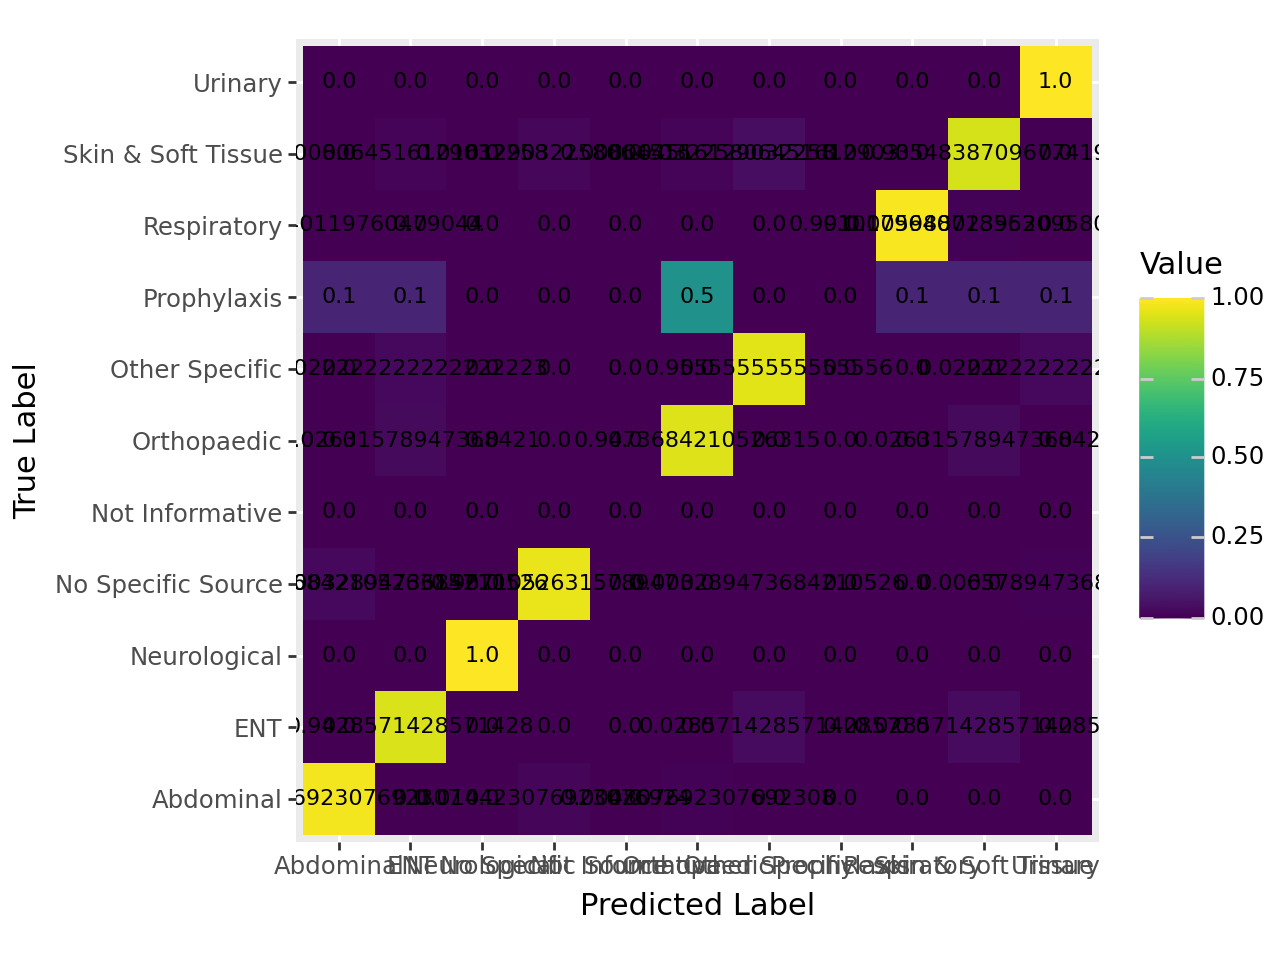

In [12]:
true_list = true_flat_dict["oxford"]
pred_list = pred_flat_dict["oxford"]

cm = confusion_matrix(
    true_list, 
    pred_list,
    labels=categoires_no_uncertainty,
    normalize='true')

cm_long = (
    pl.DataFrame(cm, schema=categoires_no_uncertainty)
    .with_columns(
        pl.Series("True Label", categoires_no_uncertainty),
    )
    .melt(id_vars=["True Label"], value_vars=categoires_no_uncertainty, variable_name="Predicted Label", value_name="Value")
)

(
    ggplot(cm_long.to_pandas(), aes(x="Predicted Label", y="True Label", fill="Value"))
    + geom_tile()
    + geom_text(aes(label="Value"), color="black", size=8)
    + coord_equal()
)

## Export Raw Data
Give up plotting it in Python and just replot in ggplot...

In [13]:
Path.cwd()

PosixPath('/home/kevinyuan/EHR-Indication-Processing/03_Evaluation')

In [17]:
for test_location in test_location_list:
    # cm_long_dict[test_location].to_csv(data_dir / "export" / model_name / f"{model_name}_{test_location}_confusion_matrix.csv", write_header=True)
    # f1_scores_dict[test_location].to_csv(data_dir / "export" / model_name / f"{model_name}_{test_location}_f1_scores.csv", write_header=True)
    cm_long_dict[test_location].write_csv(Path.cwd() / "tmp" / f"{model_name}_{test_location}_confusion_matrix_long.csv")
    f1_scores_dict[test_location].write_csv(Path.cwd() / "tmp" / f"{model_name}_{test_location}_f1_scores.csv")